In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
np.random.seed(0)
# random.seed(0)

torch.random.manual_seed(0) 

In [2]:
# reading the data
dataset = pd.read_csv('costsensitiveregression.csv')
X = dataset.drop(['Status'], axis=1)
y = dataset['Status']

In [3]:
print(f"Percentage of label 1 samples: {np.sum(y==1)*100/len(y)}%")
print(f"Percentage of label 0 samples: {np.sum(y==0)*100/len(y)}%")

Percentage of label 1 samples: 29.858571080224337%
Percentage of label 0 samples: 70.14142891977566%


Dataset is moderately imbalanced label 1 samples are almost half as compared to label 0.

In [4]:
dataset.describe()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
count,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,147636.000000,1.476360e+05
mean,7.722107,15.220908,0.253245,0.027062,0.050789,0.021648,0.071709,0.271927,0.493587,0.045045,0.013474,0.298586,5.334049e+02
std,7.574278,7.596921,0.366280,0.335509,0.373370,0.298285,1.135755,2.432425,0.763389,0.182274,0.100973,0.457639,8.774011e+03
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,10.000000,0.001084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.820820e-01
50%,4.000000,19.000000,0.033354,0.000000,0.000000,0.000000,0.000000,0.000000,0.097875,0.000000,0.000000,0.000000,1.183562e+01
75%,13.000000,21.000000,0.394372,0.000000,0.000000,0.000000,0.000000,0.061840,0.880929,0.000000,0.000000,1.000000,1.069840e+02
max,23.000000,22.000000,1.000000,79.837480,51.944780,61.556900,209.021870,399.606420,5.000000,1.000000,1.000000,1.000000,1.703186e+06


In [5]:
dataset.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [6]:
# checking the statistics of the False Negative Cost
dataset['FNC'].describe()

count    1.476360e+05
mean     5.334049e+02
std      8.774011e+03
min      0.000000e+00
25%      2.820820e-01
50%      1.183562e+01
75%      1.069840e+02
max      1.703186e+06
Name: FNC, dtype: float64

Majority (~75%) of values in PFD, PFG, SFD, SFG, AH and AN are zero, indicating the label 0 values more likely corresponds to them

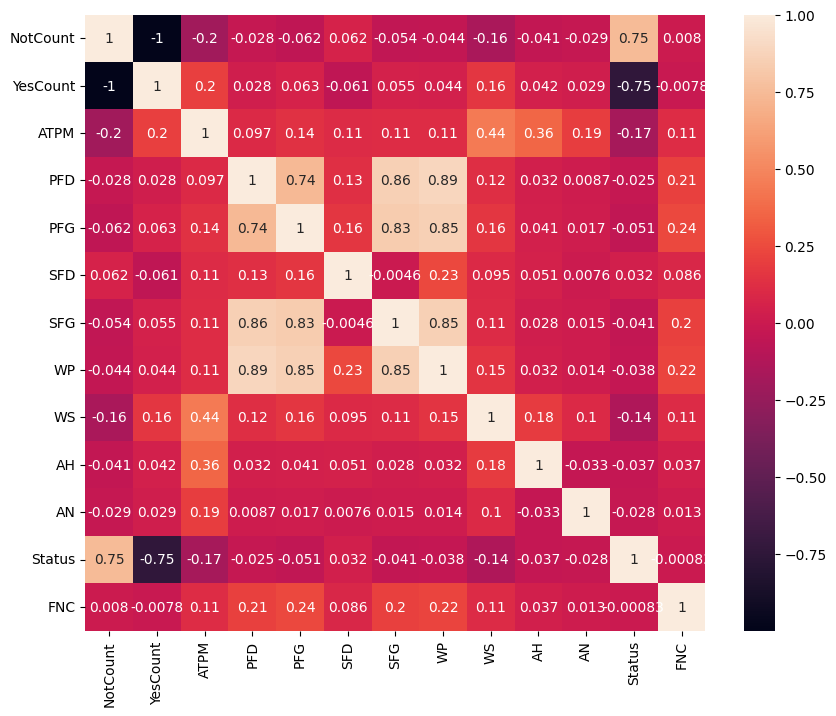

In [7]:
import seaborn as sns
ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(dataset.corr(), annot=True)

In [8]:
# Splitting the data

X = dataset[['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN']]
Y = dataset['Status']
FN = dataset['FNC']

Status is highly correlated to NotCount & YesCount which means they can give good accuracy using logistic regression.

In [9]:
# converting into torch tensors from Pandas

X_ten = torch.tensor(X.values, dtype=torch.float32)
Y_ten = torch.tensor(Y.values, dtype=torch.float32)

TP_ten = torch.tensor([6 for i in range(len(Y_ten))], dtype=torch.float32)
FP_ten = torch.tensor([6 for i in range(len(TP_ten))], dtype=torch.float32)
TN_ten = torch.tensor([0 for i in range(len(TP_ten))], dtype=torch.float32)
FN_ten = torch.tensor(FN.values, dtype=torch.float32)

In [10]:
# performing test-train 80-20
indices = np.arange(len(dataset) , dtype = np.int64)
np.random.seed(0)
np.random.shuffle(indices)
# print(indices)

train_indices = indices[:int(len(dataset)*0.8)].tolist()
test_indices = indices[int(len(dataset)*0.8):].tolist()

In [11]:
X_train = X_ten[train_indices]
Y_train = Y_ten[train_indices].reshape(-1,1)
X_test = X_ten[test_indices]
Y_test = Y_ten[test_indices].reshape(-1,1)

TP_train = TP_ten[train_indices].reshape(-1,1)
TP_test = TP_ten[test_indices].reshape(-1,1)
FP_train = FP_ten[train_indices].reshape(-1,1)
FP_test = FP_ten[test_indices].reshape(-1,1)
TN_train = TN_ten[train_indices].reshape(-1,1)
TN_test = TN_ten[test_indices].reshape(-1,1)
FN_train = FN_ten[train_indices].reshape(-1,1)
FN_test = FN_ten[test_indices].reshape(-1,1)

# # we want to normalize the False negative cost values to values between 0 and 5 
# # since other costs are approximately equal to 4 
# # we normalize the testing set also using training set values
FN_train_max = torch.max(FN_train)
FN_train_min = torch.min(FN_train)

FN_train = (FN_train - FN_train_min)/(FN_train_max - FN_train_min) * 5
FN_test= (FN_test - FN_train_min)/(FN_train_max - FN_train_min) * 5

# using these normalized FN as a feature
X_train = torch.hstack((X_train, FN_train))
X_test = torch.hstack((X_test, FN_test))

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        # Creating a one-layer Neural Network
        self.fc1 = nn.Linear(input_dim, output_dim)
        # Initializing the weights: Kaiming uniform initialization
        torch.nn.init.kaiming_uniform_(self.fc1.weight , a=0)
        # self.fc1.weight.data.fill_(0)
        
    def forward(self, x):
        # Applying sigmoid to output to convert into probability
        return torch.sigmoid(self.fc1(x))

In [13]:

def BahnsenLoss(y, y_hat, fn_weight):
    # Binary cross entropy loss
    bce_loss = nn.BCELoss()(y_hat, y)
    # Weighted loss with false negative cost
    weighted_loss = bce_loss + torch.mean(fn_weight * (y * (1 - y_hat)))
    return weighted_loss

Epoch 1/40 : Train Loss = 4.3792 , Test Loss = 4.3306
Epoch 2/40 : Train Loss = 4.3441 , Test Loss = 4.2942
Epoch 3/40 : Train Loss = 4.3084 , Test Loss = 4.2578
Epoch 4/40 : Train Loss = 4.2719 , Test Loss = 4.2214
Epoch 5/40 : Train Loss = 4.2355 , Test Loss = 4.1851
Epoch 6/40 : Train Loss = 4.1992 , Test Loss = 4.1516
Epoch 7/40 : Train Loss = 4.1628 , Test Loss = 4.1153
Epoch 8/40 : Train Loss = 4.1265 , Test Loss = 4.0791
Epoch 9/40 : Train Loss = 4.0903 , Test Loss = 4.0429
Epoch 10/40 : Train Loss = 4.0548 , Test Loss = 4.0068
Epoch 11/40 : Train Loss = 4.0186 , Test Loss = 3.9707
Epoch 12/40 : Train Loss = 3.9824 , Test Loss = 3.9347
Epoch 13/40 : Train Loss = 3.9463 , Test Loss = 3.8987
Epoch 14/40 : Train Loss = 3.9103 , Test Loss = 3.8627
Epoch 15/40 : Train Loss = 3.8743 , Test Loss = 3.8240
Epoch 16/40 : Train Loss = 3.8383 , Test Loss = 3.7882
Epoch 17/40 : Train Loss = 3.8025 , Test Loss = 3.7524
Epoch 18/40 : Train Loss = 3.7667 , Test Loss = 3.7167
Epoch 19/40 : Train

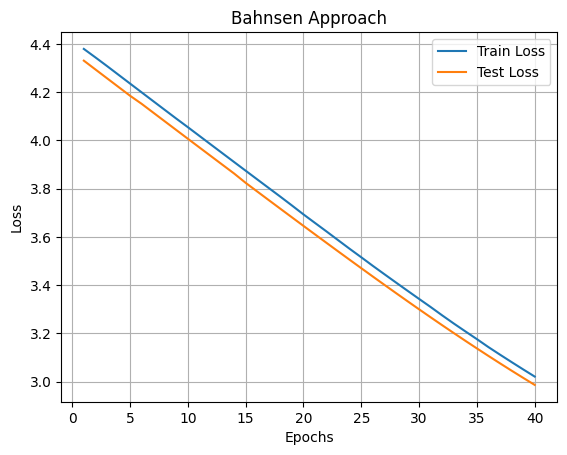

In [14]:

epochs = 40
fn_weight = torch.tensor(5, dtype=torch.float32)  # False negative cost weight
train_losses = []
test_losses = []
model = LogisticRegression(12, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = BahnsenLoss(Y_train, y_hat_probs, fn_weight)
    
    # Setting gradients to zero
    optimizer.zero_grad()
    # Calculating gradients using backpropagation
    loss.backward()
    # Updating weights
    optimizer.step()

    # Appending training loss
    train_losses.append(loss.item())

    # Testing loss
    y_hat_probs_test = model(X_test)
    loss_test = BahnsenLoss(Y_test, y_hat_probs_test, fn_weight)
    test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs} : Train Loss = {loss.item():.4f} , Test Loss = {loss_test.item():.4f}')

# Plotting the losses vs epochs
ticks = [i for i in range(1, epochs+1)]
plt.title('Bahnsen Approach')
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [15]:
# calculating the accuracy
y_hat_bahnsen = model(X_test)
Y_hat_bahnsen = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_bahnsen], dtype=torch.float32).reshape(-1,1)
print("Accuracy is {}".format((Y_hat_bahnsen == Y_test).sum().item()/len(Y_test) * 100))

Accuracy is 69.17163370360336


In [16]:
# Calculate misclassifications for Bahnsen approach

TP_bahnsen = ((Y_test == 1) & (Y_hat_bahnsen == 1)).sum().item()
FP_bahnsen = ((Y_test == 0) & (Y_hat_bahnsen == 1)).sum().item()
TN_bahnsen = ((Y_test == 0) & (Y_hat_bahnsen == 0)).sum().item()
FN_bahnsen = ((Y_test == 1) & (Y_hat_bahnsen == 0)).sum().item()


In [17]:
def NikouGunnemannLoss(y, y_hat, tp, fp, fn, tn):
    loss = torch.mean(y * (y_hat * (1 - fn) + (1 - y_hat) * fp) + (1 - y) * (y_hat * fn + (1 - y_hat) * tn))
    loss.requires_grad_()
    return loss

Epoch 1/40 : Train Loss = 0.3003 , Test Loss = 0.2998
Epoch 2/40 : Train Loss = 0.3002 , Test Loss = 0.2997
Epoch 3/40 : Train Loss = 0.3001 , Test Loss = 0.2997
Epoch 4/40 : Train Loss = 0.3000 , Test Loss = 0.2996
Epoch 5/40 : Train Loss = 0.3000 , Test Loss = 0.2995
Epoch 6/40 : Train Loss = 0.2999 , Test Loss = 0.2994
Epoch 7/40 : Train Loss = 0.2998 , Test Loss = 0.2994
Epoch 8/40 : Train Loss = 0.2998 , Test Loss = 0.2993
Epoch 9/40 : Train Loss = 0.2997 , Test Loss = 0.2993
Epoch 10/40 : Train Loss = 0.2997 , Test Loss = 0.2992
Epoch 11/40 : Train Loss = 0.2997 , Test Loss = 0.2992
Epoch 12/40 : Train Loss = 0.2996 , Test Loss = 0.2992
Epoch 13/40 : Train Loss = 0.2996 , Test Loss = 0.2991
Epoch 14/40 : Train Loss = 0.2996 , Test Loss = 0.2991
Epoch 15/40 : Train Loss = 0.2995 , Test Loss = 0.2991
Epoch 16/40 : Train Loss = 0.2995 , Test Loss = 0.2991
Epoch 17/40 : Train Loss = 0.2995 , Test Loss = 0.2990
Epoch 18/40 : Train Loss = 0.2995 , Test Loss = 0.2990
Epoch 19/40 : Train

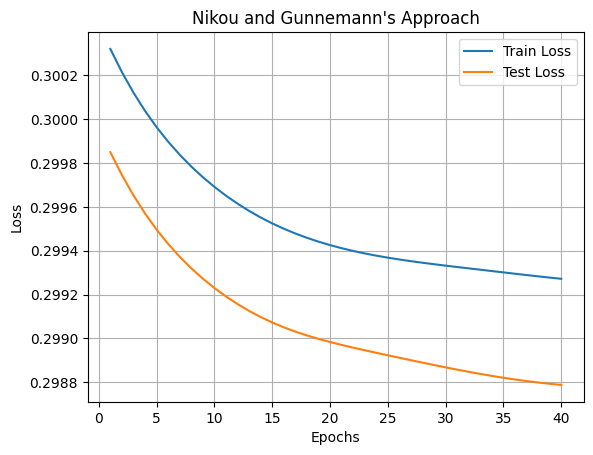

In [18]:
epochs = 40
tp = 6  # true positive cost
fp = 6  # false positive cost
tn = 0  # true negative cost
train_losses = []
test_losses = []
model = LogisticRegression(12, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = NikouGunnemannLoss(Y_train, y_hat_probs, TP_train, FP_train, FN_train, TN_train)  # Use FN_train directly
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    y_hat_probs_test = model(X_test)
    loss_test = NikouGunnemannLoss(Y_test, y_hat_probs_test, tp, fp, FN_test, tn)  # Use FN_test directly
    test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs} : Train Loss = {loss.item():.4f} , Test Loss = {loss_test.item():.4f}')

# Plotting the losses vs epochs
ticks = [i for i in range(1, epochs+1)]
plt.title("Nikou and Gunnemann's Approach")
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [19]:
# calculating the accuracy
y_hat_nikou = model(X_test)
Y_hat_nikou = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_nikou], dtype=torch.float32).reshape(-1,1)
print("Accuracy is {}".format((Y_hat_nikou == Y_test).sum().item()/len(Y_test) * 100))

Accuracy is 29.89366025467353


In [20]:
# Calculate misclassifications for Nikou Gunnemann's approach
TP_nikou = ((Y_test == 1) & (Y_hat_nikou == 1)).sum().item()
FP_nikou = ((Y_test == 0) & (Y_hat_nikou == 1)).sum().item()
TN_nikou = ((Y_test == 0) & (Y_hat_nikou == 0)).sum().item()
FN_nikou = ((Y_test == 1) & (Y_hat_nikou == 0)).sum().item()

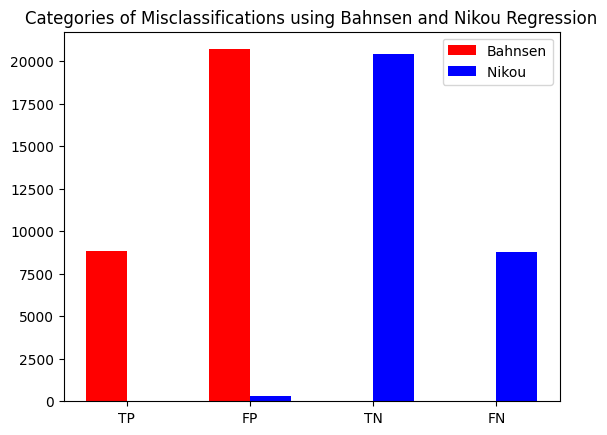

In [21]:
# comparing the number of misclassifcations for Nikou and Bahnsen regression

bar1 = [TP_nikou, FP_nikou, TN_nikou, FN_nikou]
bar2 = [TP_bahnsen, FP_bahnsen, TN_bahnsen,FN_bahnsen]

br1 = np.arange(4)
width = 0.33
br2 = [x + width for x in br1]

plt.bar(br1, bar1, color ='r', width = width, label ='Bahnsen')
plt.bar(br2, bar2, color ='b', width = width,  label ='Nikou ')
plt.legend()
plt.xticks([x - width/2 for x in br2], ['TP', 'FP', 'TN', 'FN'])
plt.title("Categories of Misclassifications using Bahnsen and Nikou Regression")
plt.show()